# 1| Import our important libraries

In [3]:
# libraries for system
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



#import DL libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


#  Data preprocessing

In [4]:
train_dir = '/kaggle/input/emotion-detection-fer/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
train_df

,filepaths,labels
0,/kaggle/input/emotion-detection-fer/train/fear...,fearful
1,/kaggle/input/emotion-detection-fer/train/fear...,fearful
2,/kaggle/input/emotion-detection-fer/train/fear...,fearful
3,/kaggle/input/emotion-detection-fer/train/fear...,fearful
4,/kaggle/input/emotion-detection-fer/train/fear...,fearful
...,...,...
28704,/kaggle/input/emotion-detection-fer/train/happ...,happy
28705,/kaggle/input/emotion-detection-fer/train/happ...,happy
28706,/kaggle/input/emotion-detection-fer/train/happ...,happy
28707,/kaggle/input/emotion-detection-fer/train/happ...,happy


In [6]:
# Generate  test data paths with labels
test_dir = '/kaggle/input/emotion-detection-fer/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
test_df

,filepaths,labels
0,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
1,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
2,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
3,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
4,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
...,...,...
7173,/kaggle/input/emotion-detection-fer/test/happy...,happy
7174,/kaggle/input/emotion-detection-fer/test/happy...,happy
7175,/kaggle/input/emotion-detection-fer/test/happy...,happy
7176,/kaggle/input/emotion-detection-fer/test/happy...,happy


# Splitting the dataframe into train , valid and test

In [9]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

# Image Data Generator

In [11]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 28709 validated image filenames belonging to 7 classes.
Found 1723 validated image filenames belonging to 7 classes.
Found 1149 validated image filenames belonging to 7 classes.


#  Showing sample from our train data

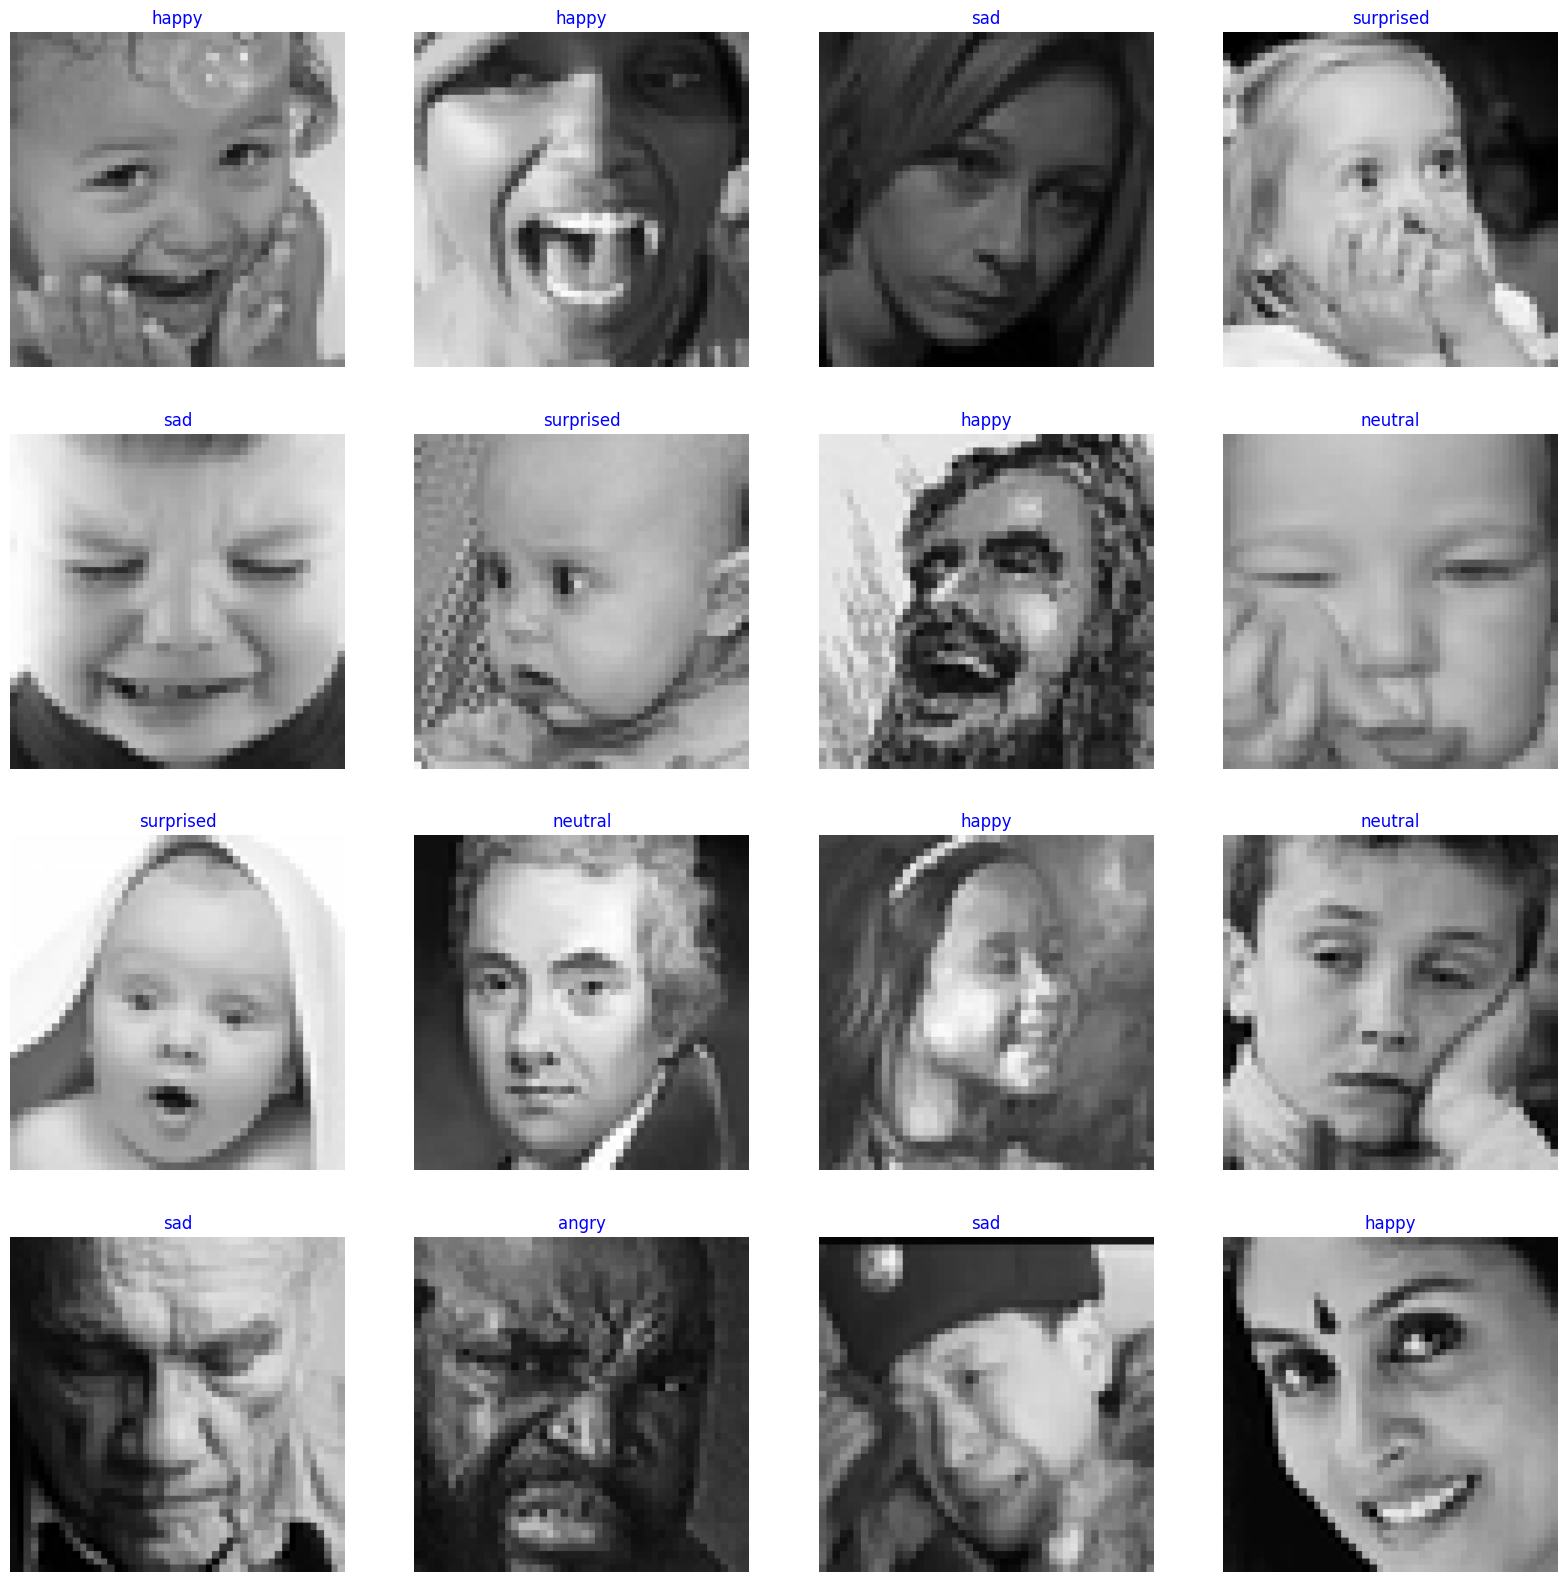

In [12]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

#  Model structure - EfficientNetB7 


In [13]:
#Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
modelEff = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

modelEff.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


modelEff.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                       

In [14]:
batch_size = 20   # set batch size for training
epochs =  5 # number of all epochs in training

historyEff = modelEff.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)




Epoch 1/5


2025-01-06 00:13:40.386901: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1736122431.209358     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1795/1795 [==============================] - 1615s 842ms/step - loss: 4.7481 - accuracy: 0.5002 - val_loss: 2.1142 - val_accuracy: 0.5990
Epoch 2/5
1795/1795 [==============================] - 1508s 840ms/step - loss: 1.6039 - accuracy: 0.6193 - val_loss: 1.3388 - val_accuracy: 0.6146
Epoch 3/5
1795/1795 [==============================] - 1507s 840ms/step - loss: 1.2297 - accuracy: 0.6621 - val_loss: 1.2412 - val_accuracy: 0.6489
Epoch 4/5
1795/1795 [==============================] - 1508s 840ms/step - loss: 1.0134 - accuracy: 0.7349 - val_loss: 1.2469 - val_accuracy: 0.6541
Epoch 5/5
1795/1795 [==============================] - 1507s 840ms/step - loss: 0.8707 - accuracy: 0.7855 - val_loss: 1.2215 - val_accuracy: 0.6634


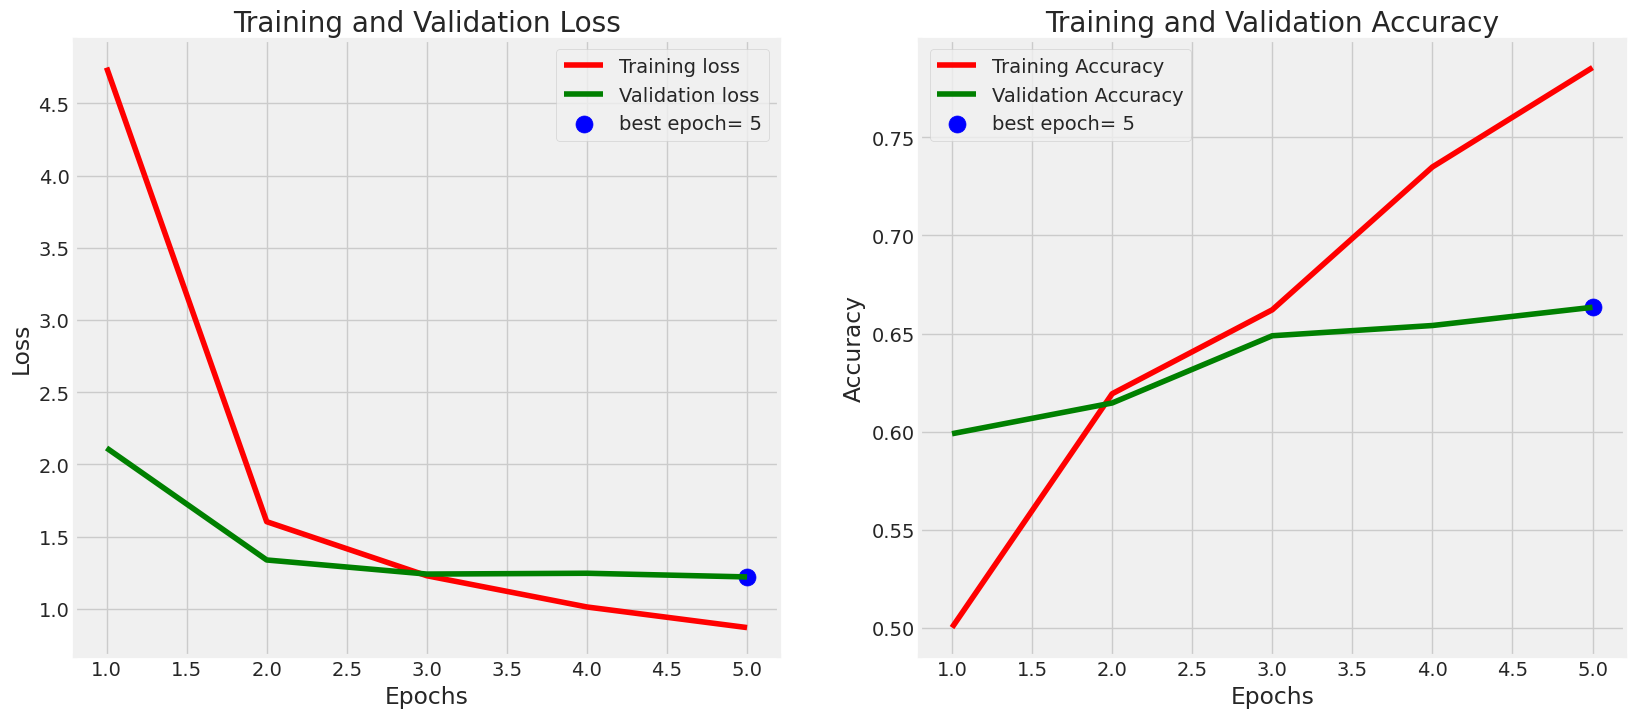

In [16]:
# Define needed variables
tr_acc = historyEff.history['accuracy']
tr_loss = historyEff.history['loss']
val_acc = historyEff.history['val_accuracy']
val_loss = historyEff.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

# Evaluate the model

In [17]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = modelEff.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = modelEff.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = modelEff.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

383/383 [==============================] - 16s 40ms/step - loss: 1.1375 - accuracy: 0.6902
Train Loss:  0.5857855677604675
Train Accuracy:  0.8857702612876892
--------------------
Validation Loss:  1.2214773893356323
Validation Accuracy:  0.6633778214454651
--------------------
Test Loss:  1.1374744176864624
Test Accuracy:  0.6901653409004211


# Predictions

In [18]:
preds = modelEff.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

# confusion matrix and classification report

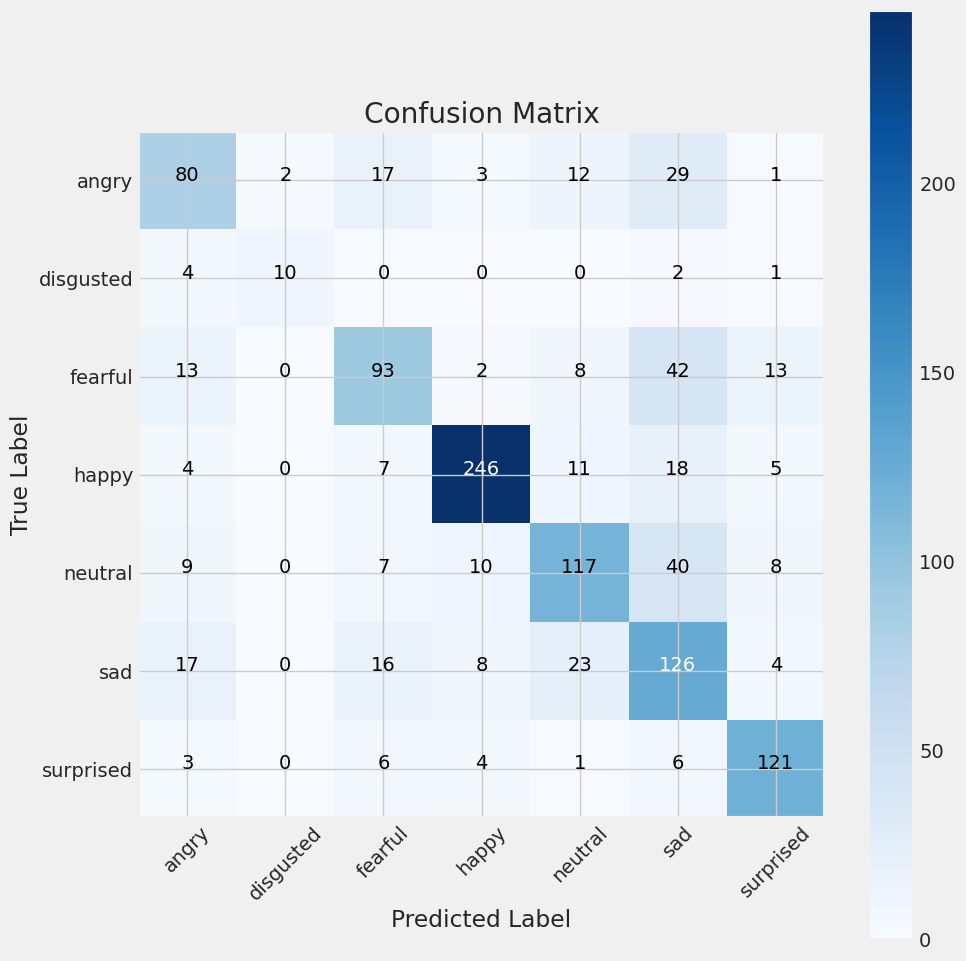

In [19]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [20]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       angry       0.62      0.56      0.58       144
   disgusted       0.83      0.59      0.69        17
     fearful       0.64      0.54      0.59       171
       happy       0.90      0.85      0.87       291
     neutral       0.68      0.61      0.64       191
         sad       0.48      0.65      0.55       194
   surprised       0.79      0.86      0.82       141

    accuracy                           0.69      1149
   macro avg       0.71      0.66      0.68      1149
weighted avg       0.70      0.69      0.69      1149



In [22]:
modelEff.save("modelEFF.h5")

In [24]:
loaded_model = tf.keras.models.load_model('/kaggle/working/modelEFF.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

1/1 [==============================] - 0s 42ms/step
happy


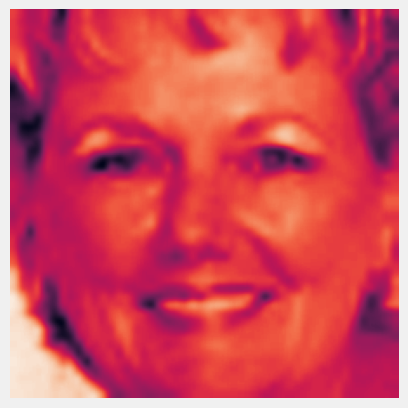

In [27]:
image_path = '/kaggle/input/emotion-detection-fer/test/happy/im1002.png'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")
plt.imshow(img)
plt.grid("off")
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 42ms/step
surprised


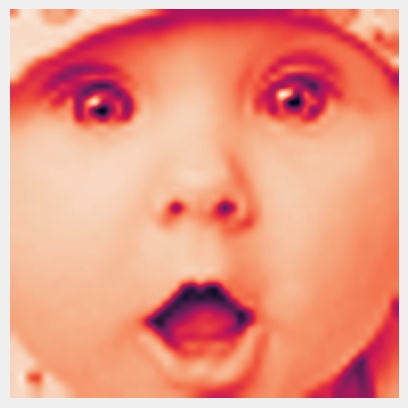

In [29]:
image_path2 = '/kaggle/input/emotion-detection-fer/test/surprised/im1.png'
image = Image.open(image_path2)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")
plt.imshow(img)
plt.grid("off")
plt.axis("off")
plt.show()

# VGG Model

In [30]:
#Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.VGG16(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
modelVGG = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

modelVGG.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

modelVGG.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 14849863 (56.65 MB)
Trainable params: 148

In [31]:
batch_size = 20   # set batch size for training
epochs =  5  # number of all epochs in training

historyVGG = modelEff.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/5
1795/1795 [==============================] - 1511s 842ms/step - loss: 0.7569 - accuracy: 0.8204 - val_loss: 1.2402 - val_accuracy: 0.6582
Epoch 2/5
1795/1795 [==============================] - 1510s 841ms/step - loss: 0.6569 - accuracy: 0.8601 - val_loss: 1.3261 - val_accuracy: 0.6640
Epoch 3/5
1795/1795 [==============================] - 1510s 841ms/step - loss: 0.5093 - accuracy: 0.9058 - val_loss: 1.3253 - val_accuracy: 0.6593
Epoch 4/5
1795/1795 [==============================] - 1509s 841ms/step - loss: 0.4410 - accuracy: 0.9216 - val_loss: 1.3487 - val_accuracy: 0.6611
Epoch 5/5
1795/1795 [==============================] - 1510s 841ms/step - loss: 0.4396 - accuracy: 0.9195 - val_loss: 1.4109 - val_accuracy: 0.6721


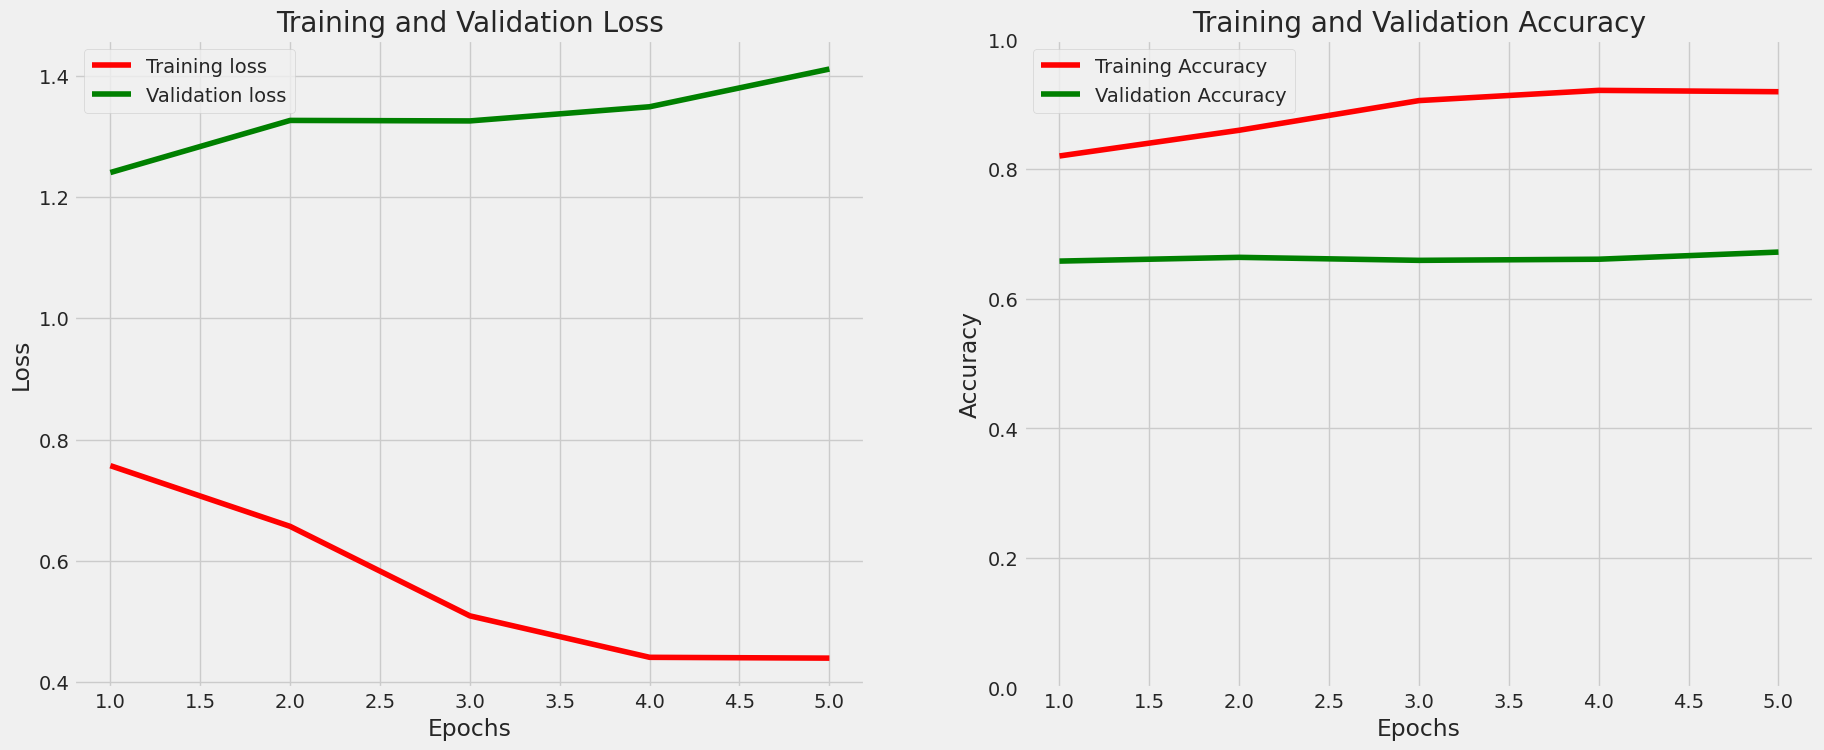

In [38]:
# Define needed variables
tr_acc = historyVGG.history['accuracy']
tr_loss = historyVGG.history['loss']
val_acc = historyVGG.history['val_accuracy']
val_loss = historyVGG.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
#acc_highest = val_acc[index_acc]
#Epochs = [i+1 for i in range(len(tr_acc))]
#loss_label = f'best epoch= {str(index_loss + 1)}'
#acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
#plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
#plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.tight_layout
plt.show()

# Predictions 

In [39]:
preds = modelVGG.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

# Confusion Metrics

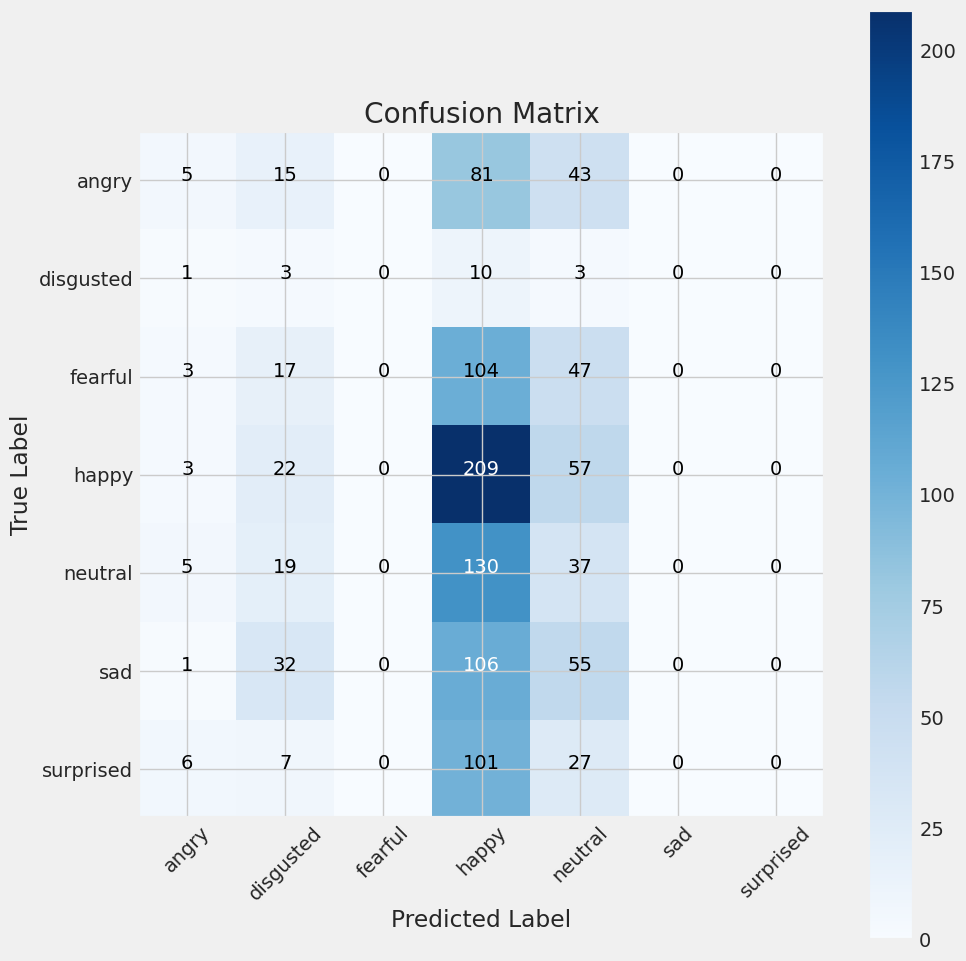

In [40]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [41]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       angry       0.21      0.03      0.06       144
   disgusted       0.03      0.18      0.05        17
     fearful       0.00      0.00      0.00       171
       happy       0.28      0.72      0.41       291
     neutral       0.14      0.19      0.16       191
         sad       0.00      0.00      0.00       194
   surprised       0.00      0.00      0.00       141

    accuracy                           0.22      1149
   macro avg       0.09      0.16      0.10      1149
weighted avg       0.12      0.22      0.14      1149



In [42]:
modelEff.save("modelVGG.h5")

# Make Predictions 

In [43]:
loaded_model = tf.keras.models.load_model('/kaggle/working/modelVGG.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

1/1 [==============================] - 5s 5s/step
happy


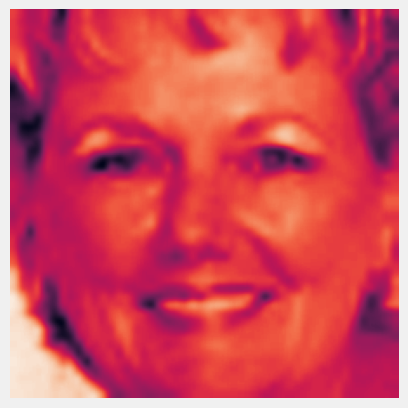

In [44]:
image_path = '/kaggle/input/emotion-detection-fer/test/happy/im1002.png'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")
plt.imshow(img)
plt.grid("off")
plt.axis("off")
plt.show()